# Sentiment analysis with Word2Vec

### Exercise objectives:
- Convert words to vectors with Word2Vec
- Use the word representation given by Word2vec to feed a RNN

<hr>

▶️ Run this cell and make sure the version of 📚 [Gensim - Word2Vec](https://radimrehurek.com/gensim/auto_examples/index.html) you are using is ≥ 4.0!

In [1]:
!pip freeze | grep gensim

gensim==4.2.0


# The data


❓ **Question** ❓ Let's first load the data. You don't have to understand what is going on in the function, it does not matter here.

⚠️ **Warning** ⚠️ The `load_data` function has a `percentage_of_sentences` argument. Depending on your computer, there are chances that too many sentences will make your compute slow down, or even freeze - your RAM can overflow. For that reason, **you should start with 10% of the sentences** and see if your computer handles it. Otherwise, rerun with a lower number. 

⚠️ **DISCLAIMER** ⚠️ **No need to play _who has the biggest_ (RAM) !** The idea is to get to run your models quickly to prototype. Even in real life, it is recommended that you start with a subset of your data to loop and debug quickly. So increase the number only if you are into getting the best accuracy.

In [2]:
import numpy as np

In [3]:
###########################################
### Just run this cell to load the data ###
###########################################

import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import text_to_word_sequence

def load_data(percentage_of_sentences=None):
    train_data, test_data = tfds.load(name="imdb_reviews", split=["train", "test"], batch_size=-1, as_supervised=True)

    train_sentences, y_train = tfds.as_numpy(train_data)
    test_sentences, y_test = tfds.as_numpy(test_data)
    
    # Take only a given percentage of the entire data
    if percentage_of_sentences is not None:
        assert(percentage_of_sentences> 0 and percentage_of_sentences<=100)
        
        len_train = int(percentage_of_sentences/100*len(train_sentences))
        train_sentences, y_train = train_sentences[:len_train], y_train[:len_train]
  
        len_test = int(percentage_of_sentences/100*len(test_sentences))
        test_sentences, y_test = test_sentences[:len_test], y_test[:len_test]
    
    X_train = [text_to_word_sequence(_.decode("utf-8")) for _ in train_sentences]
    X_test = [text_to_word_sequence(_.decode("utf-8")) for _ in test_sentences]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_data(percentage_of_sentences=10)

2023-12-22 15:59:17.514916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1FZC0M/imdb_reviews-train.tfrecord*...…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1FZC0M/imdb_reviews-test.tfrecord*...:…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1FZC0M/imdb_reviews-unsupervised.tfrec…

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2023-12-22 16:00:37.707588: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In the previous exercise, you trained a Word2vec representation and converted all your training sentences in order to feed them into a RNN, as shown in the first step of this Figure: 

<img src="word2vec_representation.png" width="400px" />



❓ **Question** ❓ Here, let's re-do exactly what you have done in the previous exercise. First, train a word2vec model (with the arguments that you want) on your training sentence. Store it into the `word2vec` variable.

In [4]:
from gensim.models import Word2Vec

# Define Word2Vec parameters
vector_size = 100  # Size of the word vectors
window = 5         # Context window size
min_count = 5      # Minimum word count to include a word in the vocabulary

# Train the Word2Vec model
word2vec = Word2Vec(sentences=X_train, vector_size=vector_size, window=window, min_count=min_count)

Let's reuse the functions of the previous exercise to convert your training and test data into something you can feed into a RNN.

❓ **Question** ❓ Read the following function to be sure you understand what is going on, and run it.

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed = embedding(word2vec, X_train)
X_test_embed = embedding(word2vec, X_test)


# Pad the training and test embedded sentences
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=200)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=200)

☝️ To be sure that it worked, let's check the following for `X_train_pad` and `X_test_pad`:
- they are numpy arrays
- they are 3-dimensional
- the last dimension is of the size of your word2vec embedding space (you can get it with `word2vec.wv.vector_size`
- the first dimension is of the size of your `X_train` and `X_test`

✅ **Good Practice** ✅ Such tests are quite important! Not only in this exercise, but in real-life applications. It prevents from finding errors too late and from letting them propagate through the entire notebook.

In [6]:
# TEST ME
for X in [X_train_pad, X_test_pad]:
    assert type(X) == np.ndarray
    assert X.shape[-1] == word2vec.wv.vector_size


assert X_train_pad.shape[0] == len(X_train)
assert X_test_pad.shape[0] == len(X_test)

# Baseline model

It is always good to have a very simple model to test your own model against - to be sure you are doing something better than a very simple algorithm.

❓ **Question** ❓ What is your baseline accuracy? In this case, your baseline can be to predict the label that is the most present in `y_train` (of course, if the dataset is balanced, the baseline accuracy is 1/n where n is the number of classes - 2 here).

In [7]:
from collections import Counter
import numpy as np

# Count the frequency of each label in y_train
label_counts = Counter(y_train)

# Find the most common label
most_common_label, most_common_count = label_counts.most_common(1)[0]

# Calculate the baseline accuracy
baseline_accuracy = most_common_count / len(y_train)

print("Baseline Accuracy:", baseline_accuracy)

Baseline Accuracy: 0.506


# The model

❓ **Question** ❓ Write a RNN with the following layers:
- a `Masking` layer
- a `LSTM` with 20 units and `tanh` activation function
- a `Dense` with 10 units
- an output layer that depends on your task

Then, compile your model (we advise you to use the `rmsprop` as the optimizer - at least to begin with)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking

# Assuming you know the embedding size (e.g., 100 for Word2Vec embeddings)
embedding_size = 100

# Create the model
model = Sequential()

# Add a Masking layer
model.add(Masking(mask_value=0.0, input_shape=(None, embedding_size)))  # Specify the input shape

# Add an LSTM layer with 20 units and tanh activation
model.add(LSTM(20, activation='tanh'))

# Add a Dense layer with 10 units
model.add(Dense(10, activation='relu'))

# Add an output layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Now, the model summary should work
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, None, 100)         0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                9680      
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,901
Trainable params: 9,901
Non-trainable params: 0
_________________________________________________________________


❓ **Question** ❓ Fit the model on your embedded and padded data - do not forget the early stopping criterion.

❗ **Remark** ❗ Your accuracy will greatly depend on your training corpus. Here just make sure that your performance is above the baseline model (which should be the case even if you loaded only 20% of the initial IMDB data).

Epoch 1/20
79/79 [==============================] - 14s 114ms/step - loss: 0.6928 - accuracy: 0.5176 - val_loss: 0.6918 - val_accuracy: 0.5304
Epoch 2/20
79/79 [==============================] - 7s 94ms/step - loss: 0.6800 - accuracy: 0.5708 - val_loss: 0.6825 - val_accuracy: 0.5624
Epoch 3/20
79/79 [==============================] - 7s 93ms/step - loss: 0.6637 - accuracy: 0.5964 - val_loss: 0.6705 - val_accuracy: 0.5872
Epoch 4/20
79/79 [==============================] - 8s 95ms/step - loss: 0.6471 - accuracy: 0.6208 - val_loss: 0.6644 - val_accuracy: 0.6024
Epoch 5/20
79/79 [==============================] - 7s 94ms/step - loss: 0.6397 - accuracy: 0.6396 - val_loss: 0.6513 - val_accuracy: 0.6212
Epoch 6/20
79/79 [==============================] - 7s 92ms/step - loss: 0.6282 - accuracy: 0.6464 - val_loss: 0.6590 - val_accuracy: 0.6092
Epoch 7/20
79/79 [==============================] - 7s 93ms/step - loss: 0.6230 - accuracy: 0.6524 - val_loss: 0.6469 - val_accuracy: 0.6256
Epoch 8/20


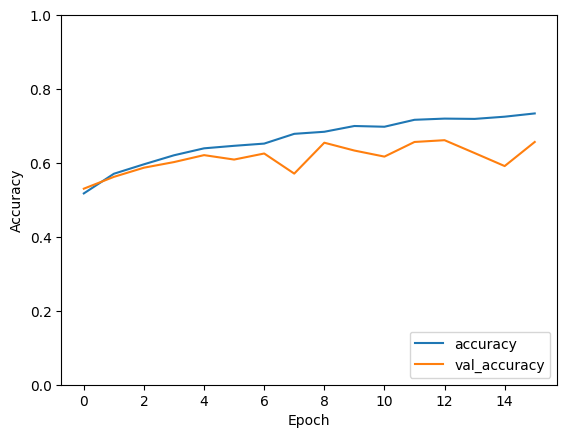

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

# Fit the model
history = model.fit(X_train_pad, y_train,
                    epochs=20,  # You can adjust the number of epochs
                    validation_data=(X_test_pad, y_test),
                    callbacks=[early_stopping])

# Check the training history (e.g., accuracy)
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

❓ **Question** ❓ Evaluate your model on the test set

In [11]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

79/79 [==============================] - 2s 19ms/step - loss: 0.6313 - accuracy: 0.6568
Test Loss: 0.6313245892524719
Test Accuracy: 0.6567999720573425


# Trained Word2Vec - Transfer Learning

Your accuracy, while above the baseline model, might be quite low. There are multiple options to improve it, as data cleaning and improving the quality of the embedding.

We won't dig into data cleaning strategies here. Let's try to improve the quality of our embedding. But instead of just loading a larger corpus, why not benefiting from the embedding that others have learned? Because, the quality of an embedding, i.e. the proximity of the words, can be derived from different tasks. This is exactly what transfer learning is.



❓ **Question** ❓ List all the different models available in the word2vec thanks to this: 

In [12]:
import gensim.downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


ℹ️ You can also find the list of the models and their size on the [`gensim-data` repository](https://github.com/RaRe-Technologies/gensim-data#models).

❓ **Question** ❓ Load one of the pre-trained word2vec embedding spaces. 

You can do that with `api.load(the-model-of-your-choice)`, and store it in `word2vec_transfer`

<details>
    <summary>💡 Hint</summary>
    
The `glove-wiki-gigaword-50` model is a good candidate to start with as it is smaller (65 MB).

</details>

In [13]:
import gensim.downloader as api

# Load the pre-trained "glove-wiki-gigaword-50" model
word2vec_transfer = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


❓ **Question** ❓ Check the size of the vocabulary, but also the size of the embedding space.

In [14]:
# Size of the vocabulary
vocab_size_transfer = len(word2vec_transfer.key_to_index)
print("Vocabulary Size:", vocab_size_transfer)

# Size of the embedding space (dimensionality of word vectors)
# We can take any word's vector to find this out
any_word = list(word2vec_transfer.key_to_index.keys())[0]
embedding_size_transfer = len(word2vec_transfer[any_word])
print("Size of Embedding Space:", embedding_size_transfer)

Vocabulary Size: 400000
Size of Embedding Space: 50


❓ Let's embed `X_train` and `X_test`, same as in the first question where we provided the functions to do so! (There is a slight difference in the `embed_sentence_with_TF` function that we will not dig into)

In [15]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

# Embed the training and test sentences
X_train_embed_2 = embedding(word2vec_transfer, X_train)
X_test_embed_2 = embedding(word2vec_transfer, X_test)

❓ **Question** ❓  Do not forget to pad your results and store it in `X_train_pad_2` and `X_test_pad_2`.

In [16]:
def pad_embedded_sequences(embedded_sequences, maxlen=None):
    """Pad embedded sequences to have the same length."""
    # Find the maximum length of any sentence (if not provided)
    if maxlen is None:
        maxlen = max(len(seq) for seq in embedded_sequences)
    
    # Pad each sequence to have the same length
    padded_sequences = np.zeros((len(embedded_sequences), maxlen, embedded_sequences[0].shape[1]))
    for i, seq in enumerate(embedded_sequences):
        if len(seq) != 0:
            padded_sequences[i, :len(seq)] = seq[:maxlen]
    
    return padded_sequences

# Determine the max length (you can set this manually to a fixed number if needed)
max_len_train = max(len(seq) for seq in X_train_embed_2)
max_len_test = max(len(seq) for seq in X_test_embed_2)
max_len = max(max_len_train, max_len_test)

# Pad the embedded sequences
X_train_pad_2 = pad_embedded_sequences(X_train_embed_2, maxlen=max_len)
X_test_pad_2 = pad_embedded_sequences(X_test_embed_2, maxlen=max_len)

❓ **Question** ❓ Reinitialize a model and fit it on your new embedded (and padded) data!  Evaluate it on your test set and compare it to your previous accuracy.

❗ **Remark** ❗ The training here could take some time. You can just compute 10 epochs (this is **not** a good practice, it is just not to wait too long) and go to the next exercise while it trains - or take a break, you probably deserve it ;)

In [19]:
# Reinitialize the model with the correct input shape
model_2 = Sequential()
model_2.add(Masking(mask_value=0.0, input_shape=(X_train_pad_2.shape[1], 50)))  # Adjust the second dimension to match the embedding size of the pre-trained model
model_2.add(LSTM(20, activation='tanh'))
model_2.add(Dense(10, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_2.fit(X_train_pad_2, y_train, epochs=10, validation_data=(X_test_pad_2, y_test))

Epoch 1/10
79/79 [==============================] - 50s 557ms/step - loss: 0.6747 - accuracy: 0.5720 - val_loss: 0.6464 - val_accuracy: 0.6336
Epoch 2/10
79/79 [==============================] - 39s 494ms/step - loss: 0.6394 - accuracy: 0.6472 - val_loss: 0.6329 - val_accuracy: 0.6388
Epoch 3/10
79/79 [==============================] - 39s 495ms/step - loss: 0.6402 - accuracy: 0.6292 - val_loss: 0.6510 - val_accuracy: 0.6492
Epoch 4/10
79/79 [==============================] - 39s 498ms/step - loss: 0.6103 - accuracy: 0.6700 - val_loss: 0.5866 - val_accuracy: 0.7012
Epoch 5/10
79/79 [==============================] - 39s 494ms/step - loss: 0.5912 - accuracy: 0.6888 - val_loss: 0.5810 - val_accuracy: 0.7084
Epoch 6/10
79/79 [==============================] - 39s 498ms/step - loss: 0.6021 - accuracy: 0.6808 - val_loss: 0.5801 - val_accuracy: 0.7036
Epoch 7/10
79/79 [==============================] - 39s 489ms/step - loss: 0.5727 - accuracy: 0.7040 - val_loss: 0.6271 - val_accuracy: 0.6692

In [20]:
res = model.evaluate(X_test_pad_2, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

InvalidArgumentError: Graph execution error:

Specified a list with shape [?,100] from a tensor with shape [32,50]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_1/lstm_1/PartitionedCall]] [Op:__inference_test_function_37640]

Because your new word2vec has been trained on a large corpus, it has a representation for many many words! Way more than with your small dataset, especially as you discarded words that were not present more than a given number of times in the train set. For that reason, you have way more embedded words in your train and test set, which makes each iteration longer than previously